In [1]:
import pandas as pd
import os
import re
PROJ_ROOT = os.path.join(os.pardir)

import gensim
import gensim .corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import itertools
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import warnings
warnings.filterwarnings('ignore')



In [2]:

url = 'https://raw.githubusercontent.com/datakind/Mar21-vaccine-uptake/main/data/twitter/twitter_data_cleaned.csv'
df = pd.read_csv(url)

users_path = os.path.join(PROJ_ROOT, 
                         'data',
                          'twitter_user.csv')

users = pd.read_csv(users_path)


In [3]:
df.head()

,tweet_id,created_at,full_text,geo,coordinates,place,retweet_count,favorite_count,possibly_sensitive,lang,user_id
0,1.364223e+18,2021-02-23 14:38:16+00:00,Here’s what's in the COVID relief package:\n \...,NaN,NaN,NaN,9160,38093,NOT FOUND,en,2.950125e+07
1,1.364381e+18,2021-02-24 01:07:52+00:00,Will the National Endowment for the Arts be he...,NaN,NaN,NaN,6131,18560,NOT FOUND,en,1.201671e+18
2,1.364610e+18,2021-02-24 16:14:15+00:00,"This is both anecdotal and early, but many lon...",NaN,NaN,NaN,5941,63174,NOT FOUND,en,3.842872e+07
3,1.364727e+18,2021-02-24 23:59:58+00:00,A Link to Professor Chossudovsky’s Analysis of...,NaN,NaN,NaN,1,0,False,en,2.192010e+09
4,1.364727e+18,2021-02-24 23:59:58+00:00,Children warned over hugging grandparents even...,NaN,NaN,NaN,0,2,False,en,2.868190e+09


In [4]:
users.head()

,user_id,user_location,user_verified,user_followers_count
0,29501253,"Burbank, CA",True,2931387
1,1201670995435646976,"Colorado, USA",True,557873
2,38428725,NaN,True,124131
3,2192010002,here & now 🇺🇸,False,2947
4,2868189989,Brighton UK and Bayonne France,False,2556


In [5]:
full_data = pd.merge(df, users,how='left', on='user_id')
full_data['created_at'] = pd.to_datetime(full_data['created_at']) # change the col to datetime
full_data.head()

,tweet_id,created_at,full_text,geo,coordinates,place,retweet_count,favorite_count,possibly_sensitive,lang,user_id,user_location,user_verified,user_followers_count
0,1.364223e+18,2021-02-23 14:38:16+00:00,Here’s what's in the COVID relief package:\n \...,NaN,NaN,NaN,9160,38093,NOT FOUND,en,2.950125e+07,"Burbank, CA",True,2931387.0
1,1.364381e+18,2021-02-24 01:07:52+00:00,Will the National Endowment for the Arts be he...,NaN,NaN,NaN,6131,18560,NOT FOUND,en,1.201671e+18,"Colorado, USA",True,557873.0
2,1.364610e+18,2021-02-24 16:14:15+00:00,"This is both anecdotal and early, but many lon...",NaN,NaN,NaN,5941,63174,NOT FOUND,en,3.842872e+07,NaN,True,124131.0
3,1.364727e+18,2021-02-24 23:59:58+00:00,A Link to Professor Chossudovsky’s Analysis of...,NaN,NaN,NaN,1,0,False,en,2.192010e+09,here & now 🇺🇸,False,2947.0
4,1.364727e+18,2021-02-24 23:59:58+00:00,Children warned over hugging grandparents even...,NaN,NaN,NaN,0,2,False,en,2.868190e+09,Brighton UK and Bayonne France,False,2556.0


In [6]:
nlp = spacy.load("en_core_web_lg") # import spacy model

In [7]:
# additional stop words to be removed from the vocabulary
# added the search terms from the github search page, with the exception of doses & pandemic
# 'rt' were added
stop_words = {'covid','covid-19','covid19','carona','corona','carona virus','covid 19',
              'caronavirus','coronavirus', 'vaccine','vaccinate', 'vaccination', 'virus',
              'sarscov2','vax', 'vaccination', 'pfizer', 'moderna', 'vaccine', 'antivax',
              'anti-vax','vaccinated','#herdimmunity','#firefauci', '#vaccinated','#vaccineswork', '#bigpharma',
              '#vaxed', '#vaxxed', '#antivaccine', '#antivax','#immunity','#novaccine', '#vaccine',
              '#covid', '#coronavirus', '#covid19', 'johnson','j&j','rt','pandemic'}





In [8]:
nlp.Defaults.stop_words.update(stop_words) #update spacy stopwords to include additional words

#udpate stopwords
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop=True
    
# create lemmatize, remove_stopwords, list component spacy functions for the spacy pipeline
def lemmatize_pipe(doc):
    '''Function'''
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)

def remove_stops(doc):
    '''function removes stopwords'''
    doc = [token.text for token in doc if nlp.vocab[token.text.lower()].is_stop!= True and token.is_punct != True and token.lemma_ not in STOP_WORDS]
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)

def list_component(doc):
    '''This pipeline returns a list of tokens vs a spacy doc object'''
    tokens = [token.text for token in doc]
          
    return tokens

In [9]:
# add the pipes to the spacy pipeline
nlp.add_pipe(remove_stops, before='ner')
nlp.add_pipe(lemmatize_pipe, last=True)
nlp.add_pipe(list_component, last=True)

In [10]:
# add all of the tweets to one list
tweets = full_data.full_text.tolist()

# lowercase
tweets= [word.lower() for word in tweets]

# # remove the '@' and '#' symbols
# tweets=[word.replace('@','').replace('#','') for word in tweets]

# remove the '#' symbol
tweets=[word.replace('#','') for word in tweets]

# remove the '#' symbol and the '_' symbol, in the event an underscore is used for
tweets=[word.replace('@','').replace('#','')for word in tweets]
tweets = [re.sub(r'@\w+','',word)for word in tweets] # decided to remove all of the @mentions

I'm curious if @ mentions should be moved altogether or just the @ symbol. The mentions may have a certain importance to them. Folks who tweet may swap out  word for an @mention instead.

On the other hand, i've seen a lot of retweets or tweets where an extremely large amount of people are mention, but do not give any context to what is being said. This could confuse certain models (ie. sentiment)


In [11]:
# run the tweets through the pipeline
processed_tweets = list(nlp.pipe(tweets, disable=['tagger','parser','ner']))

In [12]:
# some additional cleaning
processed_tweets=[[word.replace('\n','') for word in x] for x in processed_tweets] 
processed_tweets=[[word.replace('\xa0  ','').replace('amp','') for word in x] for x in processed_tweets]
processed_tweets=[[word.strip() for word in x if len(word.strip())>0] for x in processed_tweets]

In [13]:
# create ngrams with gensim
bigram = Phrases(processed_tweets, min_count = 3)
trigram = Phrases(bigram[processed_tweets], min_count=2)
qgram = Phrases(trigram[processed_tweets], min_count=2)
fgram = Phrases(qgram[processed_tweets],min_count=2)
sgram = Phrases(fgram[processed_tweets])

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)
qgram_mod = Phraser(qgram)
fgram_mod = Phraser(fgram)
sgram_mod = Phraser(sgram)

def create_n_grams(text):
    '''Function that takes in text and returns the different ngrams'''
    return sgram[fgram_mod[qgram_mod[trigram_mod[bigram_mod[text]]]]]

In [14]:
#create a list of tokens including ngrams for each response
all_tokens = [create_n_grams(doc) for doc in processed_tweets] 

tweets_gdict= corpora.Dictionary(all_tokens) # create a gensim dictionary
corpus = [tweets_gdict.doc2bow(doc) for doc in all_tokens] # create a corpus from the dictionary

# create one long list of tokens ie. flatten out the all_tokens list of lists
texts = list(itertools.chain.from_iterable(all_tokens)) 

In [28]:
import pickle

to_save = {'all_tokens.pkl':all_tokens,'tweets_gdict.pkl':tweets_gdict,
           'corpus.pkl':corpus,'texts.pkl':texts, 'tweets.pkl':tweets,
           'processed_tweets.pkl':processed_tweets}

data_path = os.path.join(PROJ_ROOT, 
                         '_data')
for name, obj in to_save.items():
    
    with open(data_path+'\\'+name, 'wb') as f:
        pickle.dump(obj, f)
    
del to_save

In [18]:

from collections import Counter

#create a dictionary of the most used ngrams (1, 2, 3, 4+)
all_ngrams={}
for i in range(0,4):
    
    if i == 4:
        common_words = Counter([x for x in texts if x.count('_')>=i]).most_common(10)
    else:
        common_words = Counter([x for x in texts if x.count('_')==i]).most_common(10)
    
    for l in common_words:
        w,c = l

    all_ngrams[i]=common_words

### Plot ngrams over time

In [19]:
# set the index for the data to datetime
full_data = full_data.set_index('created_at')

In [20]:
print(len(all_tokens), len(full_data))

51157 51157


In [21]:
# add tokens incl ngrams to dataset
full_data['tokens'] = all_tokens

In [22]:
from collections import defaultdict

# create a list of diffent days in the dataset
date_ranges=pd.date_range(start=full_data.index.min(), end=full_data.index.max(), freq='D')
date_ranges=date_ranges.strftime('%m-%d-%Y') # reformat

# create a list of al the most common ngrams, top 10 for each ngram
top_ngrams = [words[0] for ngrams in all_ngrams.values() for words in ngrams]

# empty dictionary to hold number of ngrams for each date
ngram_by_date=defaultdict(list) 

for date in date_ranges:
    # subset the tweets for only that date from the original data
    tmp=full_data.loc[date].tokens.tolist() 
    # create one long list of words from all the tweets for that day
    tmp = [word for twt in tmp for word in twt] 
    # count the words
    cnts = Counter(tmp)
    
    # for each word in the top n_grams list
    # add into a dictionary with the date as the key and the
    # total count for that word as the value
    for w in top_ngrams:
        ngram_by_date[date].append(cnts.get(w,0))



The code above is used to create a dictionary with the top 10 words for each ngram length. It is limited to 10 to plot easier. 

It can be adjusted to create a dictionary / dataframe for all of the words in all the tweets. This way you can literally see how any word trends over time, not just the top **total** words

In [23]:
# create a dataframe from the dictionary
ngrams_by_date = pd.DataFrame.from_dict(ngram_by_date, orient='index', columns = top_ngrams)

In [24]:
from pprint import pprint

# The top 10 ngrams
pprint(all_ngrams)

{0: [('people', 4208),
     ('dose', 2668),
     ('need', 2387),
     ('know', 1843),
     ('work', 1687),
     ('today', 1594),
     ('like', 1533),
     ('time', 1532),
     ('want', 1474),
     ('think', 1426)],
 1: [('2_dose', 444),
     ('wear_mask', 398),
     ('covid_19', 264),
     ('receive_dose', 244),
     ('new_case', 241),
     ('single_dose', 225),
     ('good_news', 212),
     ('herd_immunity', 204),
     ('2nd_dose', 201),
     ('public_health', 161)],
 2: [('globally_nationalism_world', 127),
     ('people_live_economy', 127),
     ('prevent_illness_death', 95),
     ('dose_company_insist', 71),
     ('mark_j_harper', 64),
     ('total_active_case', 63),
     ('walensky_head_cdc', 53),
     ('j&;j_single_dose', 48),
     ('health_care_worker', 45),
     ('4_million_dose', 43)],
 3: [('dfreelon_black_hesitancy_headline', 164),
     ('reluctant_group_far_white', 164),
     ('republicans_large_group_https://t', 163),
     ('maryltrump_disgrace_occupant_convince', 145),
  

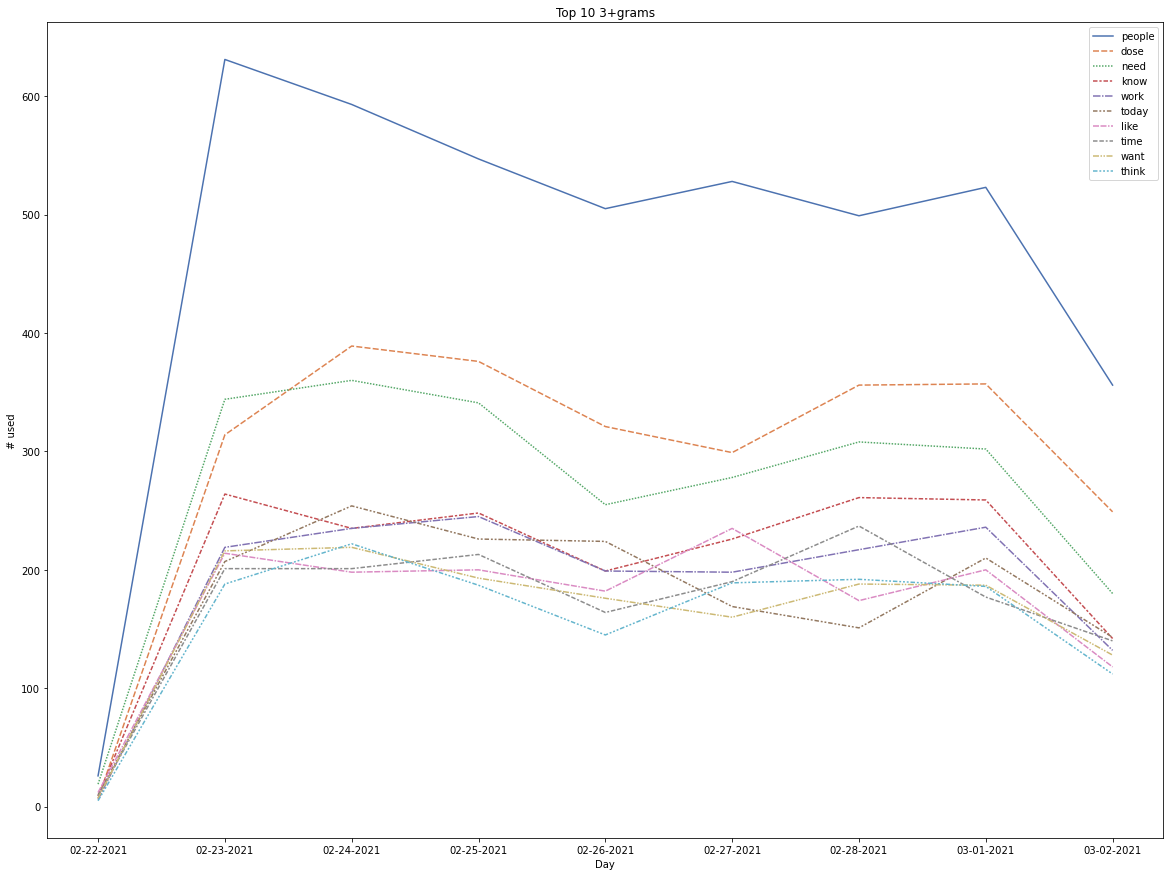

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the ngrams over time

# decide which columns to drop
# use the number '_' to decide which ngrams to show
to_drop=[x for x in ngrams_by_date.columns if x.count('_') !=0]

fig, ax = plt.subplots(figsize=(20,15))
_=sns.lineplot(data=ngrams_by_date.drop(to_drop, axis=1), palette='deep')

plt.xlabel('Day')
plt.ylabel('# used')
plt.title('Top 10 3+grams')
plt.show()
# plt.savefig('3+gram.png', bbox_inches='tight')


In [26]:
full_data.to_csv(data_path+'\\'+'full_data.csv', index=False)